# Plot corn yield figure

Create a figure that compares corn yield between Cycles-L and USDA/NASS county-level corn yield at WE-38 watershed.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from pihm import read_output
from pihm import read_mesh
from setting import WE38_YIELD
from setting import CYCLES_YIELD
from setting import MS_DIR
from my_funcs import rmse

In [9]:
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

## Read WE38 model domain and calculate grid areas

In [10]:
_, _, tri, x, y, _, _ = read_mesh('..', 'WE38')

area = [0.5 * ((x[t[1]] - x[t[0]]) * (y[t[2]] - y[t[0]]) - (y[t[1]] - y[t[0]]) * (x[t[2]] - x[t[0]])) for t in tri]
area = np.array(area)

## Read NASS county-level yield

In [11]:
obs_df = pd.read_csv(
    WE38_YIELD,
    index_col=0,
)
obs_df['yield'] = obs_df['yield'] * 0.0628 * .85
obs_df['date'] = obs_df.apply(lambda x: datetime(int(x['year']), 1, 1), axis=1)

## Read Cycles yield

In [12]:
cycles_pd = pd.read_csv(
    CYCLES_YIELD,
)
cycles_pd["date"] = cycles_pd.apply(lambda x: datetime(int(x["year"]), 1, 1), axis=1)

## Read Cycles-L yield and calculate statistics

In [13]:
crops = {
    'CornRM.90': ('grain', '#1F77B4'),
}

average_yield = {}

r2s = {}
diff_r2s = {}
rmses = {}
diff_rmses = {}

simulations = {
    'WE38': '',
}

for c in crops:
    for s in simulations:
        # Read yield output
        sim_time, _yield, _, _ = read_output('../', 'WE38', s, '%s_yield.%s' % (crops[c][0], c))
        # Filter out dates without harvests
        filter = (np.sum(_yield, axis=1) > 0)
        _yield = _yield[filter]
        _time = sim_time[filter]
        _yield[_yield == 0] = None

        _avg_yield = []
        _std = []
        for i in range(len(_time)):
            temp = _yield[i, ~np.isnan(_yield[i, :])]
            _area = area[~np.isnan(_yield[i, :])]
            temp = temp * _area / _area.mean()
            _time[i] = datetime(_time[i].year, 1, 1)
            _avg_yield.append(np.average(temp))
            _std.append(np.std(temp))

        slope, intercept, r_value, p_value, std_err = stats.linregress(obs_df['yield'], _avg_yield[0:len(obs_df['yield'])])
        rmses[s] = rmse(obs_df['yield'], _avg_yield[0:len(obs_df['yield'])])
        r2s[s] = r_value * r_value

        slope, intercept, r_value, p_value, std_err = stats.linregress(np.diff(obs_df['yield']), np.diff(_avg_yield[0:len(obs_df['yield'])]))
        diff_r2s[s] = r_value * r_value
        diff_rmses[s] = rmse(np.diff(obs_df['yield']), np.diff(_avg_yield[0:len(obs_df['yield'])]))

        average_yield[s] = (_time, _avg_yield, _std)

slope, intercept, r_value, p_value, std_err = stats.linregress(obs_df['yield'], cycles_pd["grain_yield"][0:len(obs_df['yield'])])
cycles_rmse = rmse(np.array(obs_df['yield']), np.array(cycles_pd["grain_yield"][0:len(obs_df['yield'])]))
cycles_r2 = r_value * r_value

slope, intercept, r_value, p_value, std_err = stats.linregress(np.diff(obs_df['yield']), np.diff(cycles_pd["grain_yield"][0:len(obs_df['yield'])]))
cycles_diff_r2 = r_value * r_value
cycles_diff_rmse = rmse(np.diff(obs_df['yield']), np.diff(cycles_pd["grain_yield"][0:len(obs_df['yield'])]))

## Plot

/var/folders/hg/r6hstlk92j3496vpmtz5lln40000gn/T/ipykernel_24201/3005849455.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


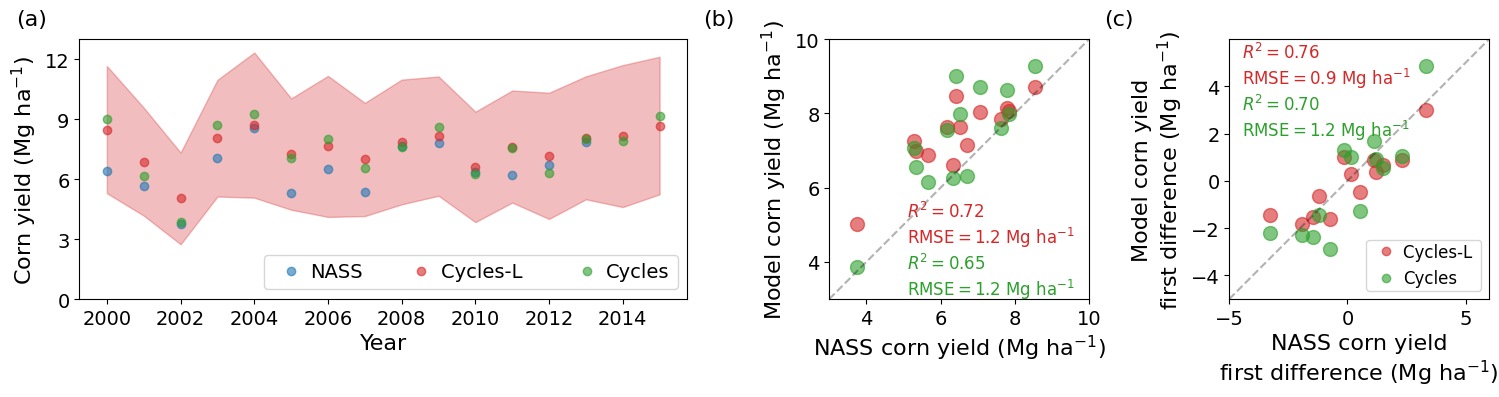

In [14]:
# Three panels
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_axes([0.05, 0.25, 0.38, 0.65])#subplot(121)
ax2 = fig.add_axes([0.5, 0.25, 0.2, 0.65])
ax3 = fig.add_axes([0.75, 0.25, 0.2, 0.65])

lines = []

_line = ax1.plot(obs_df['date'], obs_df['yield'],
    'o',
    alpha=0.6,
    color="#1F77B4",
    label='NASS',
)
lines.append(_line)

ypos = 0.34
xpos = 0.3
diff_ypos = 0.95
diff_xpos = 0.05
for c in crops:
    for s in simulations:
        x = np.array(average_yield[s][0])
        y = np.array(average_yield[s][1])
        err = np.array(average_yield[s][2])
        _line, = ax1.plot(average_yield[s][0], average_yield[s][1],
                'o',
                alpha=0.6,
                color= "#D62728",
                label='Cycles-L ' + simulations[s],
        )
        lines.append(_line)
        ax1.fill_between(x, y - err, y + err,
            color=_line.get_color(),
            alpha=0.3
        )

        ax2.plot(obs_df['yield'], average_yield[s][1][0:len(obs_df['yield'])],
            'o',
            alpha=0.6,
            ms=10,
            color=_line.get_color(),
            label='Cycles-L ' + simulations[s],
        )

        plt.text(
            xpos, ypos, 
            f'$R^2 = {r2s[s]:.2f}$',
            color=_line.get_color(),
            size=12,
            ha='left', 
            va='center', 
            transform=ax2.transAxes,
        )
        plt.text(
            xpos, ypos - 0.1, 
            f'$\mathrm{{RMSE}} = {rmses[s]:.1f}\mathrm{{~Mg~ha}}^{{-1}}$',
            color=_line.get_color(),
            size=12,
            ha='left', 
            va='center', 
            transform=ax2.transAxes,
        )
        ax3.plot(np.diff(obs_df['yield']), np.diff(average_yield[s][1][0:len(obs_df['yield'])]),
            'o',
            alpha=0.6,
            ms=10,
            color=_line.get_color(),
            label='Cycles-L ' + simulations[s],
        )
        plt.text(
            diff_xpos, diff_ypos, 
            f'$R^2 = {diff_r2s[s]:.2f}$',
            color=_line.get_color(),
            size=12,
            ha='left', 
            va='center', 
            transform=ax3.transAxes,
        )
        plt.text(
            diff_xpos, diff_ypos - 0.1, 
            f'$\mathrm{{RMSE}} = {diff_rmses[s]:.1f}\mathrm{{~Mg~ha}}^{{-1}}$',
            color=_line.get_color(),
            size=12,
            ha='left', 
            va='center', 
            transform=ax3.transAxes,
        )

_line, = ax1.plot(cycles_pd["date"], cycles_pd["grain_yield"],
    'o',
    color='#2CA02C',
    alpha=0.6,
    label='Cycles',
)
lines.append(_line)

ax2.plot(obs_df['yield'], cycles_pd["grain_yield"][0:len(obs_df['yield'])],
    'o',
    alpha=0.6,
    ms=10,
    color=_line.get_color(),
    label='Cycles',
)

plt.text(
    xpos, ypos - 0.2, 
    f'$R^2 = {cycles_r2:.2f}$',
    color=_line.get_color(),
    size=12,
    ha='left', 
    va='center', 
    transform=ax2.transAxes,
)
plt.text(
    xpos, ypos - 0.3, 
    f'$\mathrm{{RMSE}} = {cycles_rmse:.1f}\mathrm{{~Mg~ha}}^{{-1}}$',
    color=_line.get_color(),
    size=12,
    ha='left', 
    va='center', 
    transform=ax2.transAxes,
)

ax3.plot(np.diff(obs_df['yield']), np.diff(cycles_pd["grain_yield"][0:len(obs_df['yield'])]),
    'o',
    alpha=0.6,
    ms=10,
    color=_line.get_color(),
    label='Cycles',
)

plt.text(
    diff_xpos, diff_ypos - 0.2, 
    f'$R^2 = {cycles_diff_r2:.2f}$',
    color=_line.get_color(),
    size=12,
    ha='left', 
    va='center', 
    transform=ax3.transAxes,
)
plt.text(
    diff_xpos, diff_ypos - 0.3, 
    f'$\mathrm{{RMSE}} = {cycles_diff_rmse:.1f}\mathrm{{~Mg~ha}}^{{-1}}$',
    color=_line.get_color(),
    size=12,
    ha='left', 
    va='center', 
    transform=ax3.transAxes,
)

ax1.set_xlabel('Year') 
ax1.set_ylabel('Corn yield (Mg ha$^{-1}$)')
ax1.set_ylim(0, 13)
ax1.set_yticks(list(range(0, 15, 3)))
ax1.legend(
    loc='lower right',
    ncol=len(simulations) + 2,
    handletextpad=0,
)

ax2.plot([3, 10], [3, 10], 'k--', alpha=0.3)
ax2.set_xlim(3, 10)
ax2.set_ylim(3, 10)

ax2.set_aspect('equal')
ax2.set_xlabel("NASS corn yield (Mg ha$^{-1}$)")
ax2.set_ylabel("Model corn yield (Mg ha$^{-1}$)")
ax3.legend(
    handles=lines[1:],
    loc='lower right',
    handletextpad=0,
    fontsize=SMALL_SIZE - 2,
    borderpad=0.2,
)

ax3.plot([-5, 6], [-5, 6], 'k--', alpha=0.3)
ax3.set_xlim(-5., 6)
ax3.set_ylim(-5, 6)
ax3.set_yticks(list(range(-4, 6, 2)))
ax3.set_aspect('equal')
ax3.set_xlabel("NASS corn yield\nfirst difference (Mg ha$^{-1}$)")
ax3.set_ylabel("Model corn yield\nfirst difference (Mg ha$^{-1}$)")
fig.tight_layout()

fig.text(0.02, 0.95,'(a)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)
fig.text(0.45, 0.95,'(b)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)
fig.text(0.7, 0.95,'(c)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)

fig.savefig(f'{MS_DIR}/latex/yield.pdf', dpi=300)
fig.savefig(f'{MS_DIR}/figures/yield.png', dpi=300)